In [2217]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV

In [2218]:
raw_data = pd.read_csv('data.csv')
data = raw_data.copy()

### Шаг 1. Оценим данные

In [2219]:
data.head()

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Температура вдоха Истока,Температура выдоха Истока,Приток давления Выдоха Истока,Давление вдоха Истока,Давление выдоха Истока,Древний Ветер,Печать Чародея,Эмульсия Истока,Дыхание Истока,Гармония Бессмертия
0,1.138,1.54332,289.964,141.318158,6677.380,7.584,7.584,464.006,736,Исток не вернул выдох,1.096,1.394603,5.947,Древний Ветер развеялся,7.137,0.082,0.95,0.975
1,2.088,3.08664,6960.180,144.111767,6828.469,28.204,28.204,635.401,736,581.658,1.331,1.394603,7.282,1.019,10.655,0.287,0.95,0.975
2,3.144,4.62996,8379.229,145.220853,7111.811,60.358,60.358,606.002,736,Исток не вернул выдох,1.389,1.394603,7.574,Древний Ветер развеялся,13.086,0.259,0.95,0.975
3,4.161,6.17328,14724.395,162.050156,7792.630,113.774,113.774,661.471,736,Исток не вернул выдох,1.658,1.394603,9.007,Древний Ветер развеялся,18.109,0.358,0.95,0.975
4,5.140,7.71660,21636.432,201.513586,8494.777,175.306,175.306,731.494,736,645.642,2.078,1.394603,11.197,1.026,26.373,0.522,0.95,0.975


#### 1.1. Проверим на наличие пропусков, глянем на типы, количество строк, столбцов

In [2220]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Вектор Мощи                     11934 non-null  float64
 1   Скорость перехода через портал  11934 non-null  float64
 2   Приток Силы Потока              11934 non-null  float64
 3   Ритм магического ядра           11934 non-null  float64
 4   Поток Энергий                   11934 non-null  float64
 5   Сила Левого Потока              11934 non-null  float64
 6   Сила Правого Потока             11934 non-null  float64
 7   Пламя Стихий                    11934 non-null  float64
 8   Температура вдоха Истока        11934 non-null  int64  
 9   Температура выдоха Истока       11934 non-null  object 
 10  Приток давления Выдоха Истока   11934 non-null  float64
 11  Давление вдоха Истока           11934 non-null  float64
 12  Давление выдоха Истока          

#### 1.2. Узнаем количество уникальных значений в каждом столбце

In [2221]:
data.nunique()

Вектор Мощи                           9
Скорость перехода через портал        9
Приток Силы Потока                11430
Ритм магического ядра              3888
Поток Энергий                     11834
Сила Левого Потока                 4286
Сила Правого Потока                4286
Пламя Стихий                      11772
Температура вдоха Истока              1
Температура выдоха Истока          2369
Приток давления Выдоха Истока       524
Давление вдоха Истока                 1
Давление выдоха Истока             4209
Древний Ветер                        20
Печать Чародея                     8496
Эмульсия Истока                     696
Дыхание Истока                       51
Гармония Бессмертия                  26
dtype: int64

#### 1.3. Анализ по итогу предварительной оценки
1. Пропущенных значений нет.
2. Колонки 'Температура выдоха Истока' и 'Древний Ветер' имеют тип object, стоит посмотреть подробней.
3. Колонки 'Температура вдоха Истока' и 'Давление вдоха Истока' имеют единственное значение, что не имеет для нас информативности.
4. Колонки 'Вектор Мощи' и 'Скорость перехода через портал' имеют всего 9 значений, скорее категориальные признаки.
5. Колонка 'Печать Чародея' выражена в процентах, для удобства переведем в относительную величину.

### Шаг 2. Займемся преобразованием данных

#### 2.1. Начнем с очевидного, для удобства представим процентные выражения параметра 'Печать Чародея' значениями в диапазоне [0,1]

In [2222]:
data['Печать Чародея'] = data['Печать Чародея'] / 100

#### 2.2.1. Изучим колонки с типом данных 'object' <br>
Для начала возьмём только количественные значения

In [2223]:
series_to_analysis_1 = data['Температура выдоха Истока'][data['Температура выдоха Истока'] != 'Исток не вернул выдох']\
                       .astype('float64')
series_to_analysis_2 = data['Древний Ветер'][data['Древний Ветер'] != 'Древний Ветер развеялся']\
                       .astype('float64')

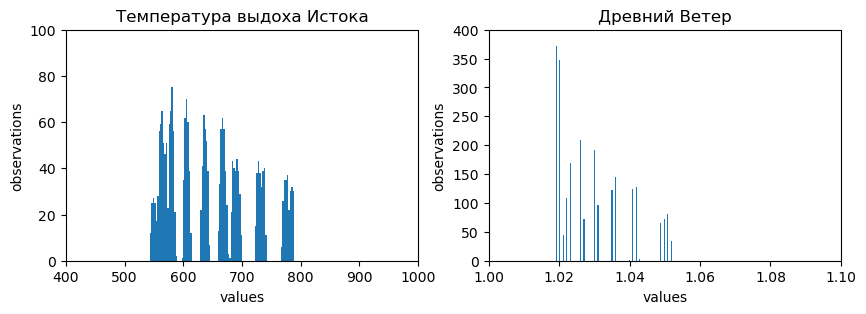

In [2224]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.hist(series_to_analysis_1, bins=100)
plt.title(series_to_analysis_1.name)
plt.xlabel('values')
plt.ylabel('observations')
plt.axis([400, 1000, 0, 100])

plt.subplot(1, 2, 2)
plt.hist(series_to_analysis_2, bins=100)
plt.title(series_to_analysis_2.name)
plt.xlabel('values')
plt.ylabel('observations')
plt.axis([1.0, 1.1, 0, 400])

plt.show()

В случае параметра 'Температура выдоха Истока' данные сосредоточены примерно вокруг температуры вдоха, равной 736. <br>
'Древний Ветер' имеет все значения чуть больше единицы. Распределения имеют явную правостороннюю асимметрию. Смущает количество наблюдений

#### 2.2.2. Проверим гипотезу о том, что отсутствующие значения в каждой из этих колонок соответствуют одним и тем же наблюдениям <br>
Другими словами, значения 'Исток не вернул выдох' и 'Древний Ветер развеялся' могут наблюдаться только совместно.

In [2225]:
obj_cols = data[['Температура выдоха Истока', 'Древний Ветер']]
obs_with_str_1 = obj_cols[obj_cols['Температура выдоха Истока'] == 'Исток не вернул выдох']
obs_with_str_2 = obj_cols[obj_cols['Древний Ветер'] == 'Древний Ветер развеялся']

obs_with_str_1.index.to_list() == obs_with_str_2.index.to_list()

True

#### 2.2.3. Гипотеза подтвердилась. Также проверим, какая доля всех наблюдений имеет такие значения <br>
Поскольку встречаются совместно, достаточно проверить на одном.

In [2226]:
vc_nan = (data['Древний Ветер'] == 'Древний Ветер развеялся').value_counts()
(vc_nan[True] / (vc_nan[True] + vc_nan[False])).round(2)

0.8

#### 2.2.4. 80% не имеют конкретного значения.  Параметр 'Древний Ветер' смело удаляю. Более того, судя по описанию, это простой выхлоп

In [2227]:
data = data.drop(['Древний Ветер'], axis=1)

#### 2.2.5. Что касается параметра 'Температура выдоха Истока', всё не так однозначно:
- параметр 'Давление выдоха Истока', судя по описанию, характеризует величину давления ветра, что вернул ускоритель, но если ускоритель его не вернул, то и сам параметр теряет смысл. Вероятно он означает нагнетенное давление, но не всегда реализующееся;
- выходит, мы должны принять нулевое значение параметра 'Давление выдоха Истока' для наблюдений без исходящего ветра;
- сам параметр 'Температура выдоха Истока' более не несет полезной информации, полагаю, его можно удалить.

In [2228]:
indexes_to_zero = data['Температура выдоха Истока'][data['Температура выдоха Истока'] == 'Исток не вернул выдох'].index
data.loc[indexes_to_zero, 'Давление выдоха Истока'] = 0

data = data.drop(['Температура выдоха Истока'], axis=1)

#### 2.3. Для удобства возможных высичлений в дальнейшем все температурные величины переведем в Кельвины

In [2229]:
data['Пламя Стихий'] = data['Пламя Стихий'] + 273.15
data['Температура вдоха Истока'] = data['Температура вдоха Истока'] + 273.15

#### 2.4.1. Сравним силы левого и правого потоков, проверим гипотезу, что они могут быть равны

In [2230]:
len(data[['Сила Левого Потока', 'Сила Правого Потока']][data['Сила Левого Потока'] != data['Сила Правого Потока']])

0

Нет ни одного наблюдения с различными значениями

#### 2.4.2. Заменим оба параметра одним суммарным

In [2231]:
opt_data = data.copy()

opt_data['Общая сила боковых потоков'] = data['Сила Левого Потока'] + data['Сила Правого Потока']
opt_data = opt_data.drop(['Сила Левого Потока', 'Сила Правого Потока'], axis=1)

#### 2.5. Рассчитаем и добавим рекомендованные оценочные показатели

In [2232]:
opt_data['Общая сила ядра'] = data['Ритм магического ядра'] * data['Приток Силы Потока'] 
opt_data['Общее давление на выдохе'] = data['Приток давления Выдоха Истока'] + data['Давление выдоха Истока']
opt_data['Магическая производительность'] = data['Скорость перехода через портал'] / data['Эмульсия Истока'] 
opt_data['Эффективность ядра'] = opt_data['Общая сила ядра'] / data['Эмульсия Истока']
opt_data['Магическая мощность'] = opt_data['Общее давление на выдохе'] * data['Эмульсия Истока'] \
                                  * (data['Пламя Стихий'] - data['Температура вдоха Истока'])

Не вижу смысла добавлять Суммарную силу потоков, т.к. параметр 'Общая сила боковых потоков' уже является замещением двух других, добавление третьего снизит гибкость модели. Пока оставлю оба. <br> 
Также не интересуют параметры, завязанные на Гармонии Бессмертия, поскольку предсказание производится в отсутсвии данного показателя и мы попросту не сможем их вычислить.

#### 2.6. Создам словарь с более удобными для восприятия названиями колонок, временно заменю в основном датасете (при желании)

In [2233]:
alias_dict = {
    'Вектор Мощи': 'Заданная интенсивность перехода',  
    'Приток Силы Потока': 'Сила потока через ядро',  
    'Ритм магического ядра': 'Скорость вращения ядра, об/мин',  
    'Поток Энергий': 'Частотота генератора эфира', 
    'Пламя Стихий': 'Температура энергии, на выходе из МИВД',  
    'Температура вдоха Истока': 'Температура воздуха на входе в ускоритель',
    'Температура выдоха Истока': 'Температура воздуха на выходе из ускорителя',  
    'Приток давления Выдоха Истока': 'Давление энергии на выходе из МИВД',  
    'Давление вдоха Истока': 'Давление воздуха на входе в ускоритель', 
    'Давление выдоха Истока': 'Давление воздуха на выходе из ускорителя',  
    'Древний Ветер': 'Давление выхлопа',  
    'Печать Чародея': 'Интенсивность впрыска топлива',  
    'Эмульсия Истока': 'Количество необходимого топлива', 
    'Дыхание Истока': 'Запас прочности ускорителя',  
    'Гармония Бессмертия': 'Запас прочности ядра', 
    'Общее давление на выдохе': 'Общее давление на выходе из источников'
}

In [2234]:
# for alias in alias_dict:
#     if alias in opt_data.columns:
#         opt_data = opt_data.rename(columns={alias: alias_dict[alias]})

#### 2.7. Изучив параметры, хочется добавить дополнительные преобразования

In [2235]:
opt_data['Мощность генератора'] = (opt_data['Общая сила боковых потоков'] + opt_data['Приток Силы Потока']) \
                                  / opt_data['Поток Энергий']

#### 2.8. Удалим колонки с одним значением

Данные были использованы для вычисления новых показателей, сами по себе они для нас бесполезны

In [2236]:
opt_data = opt_data.drop(['Температура вдоха Истока', 'Давление вдоха Истока'], axis=1)

### Шаг 3. Визуально оценим признаки на наличие аномальных значений

In [2237]:
column_names_opt_data = opt_data.columns.to_list()

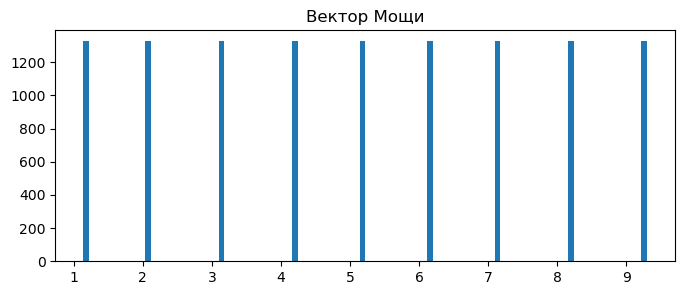

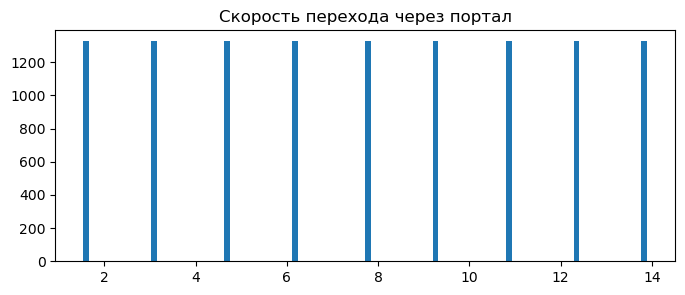

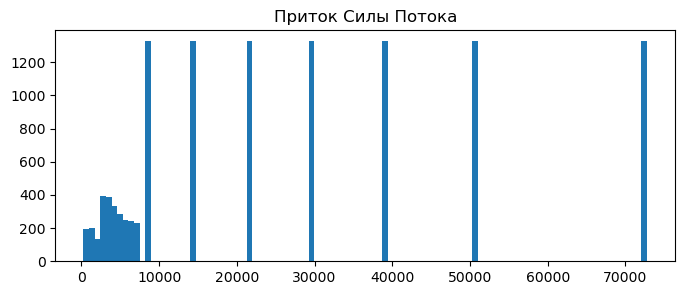

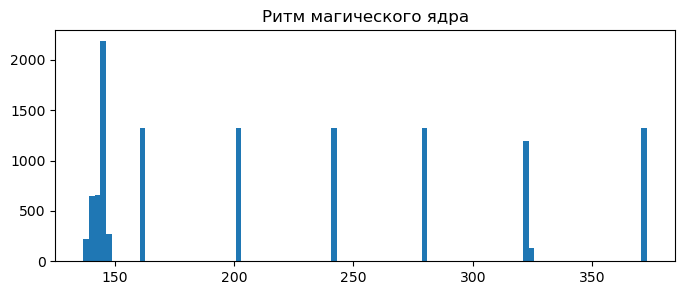

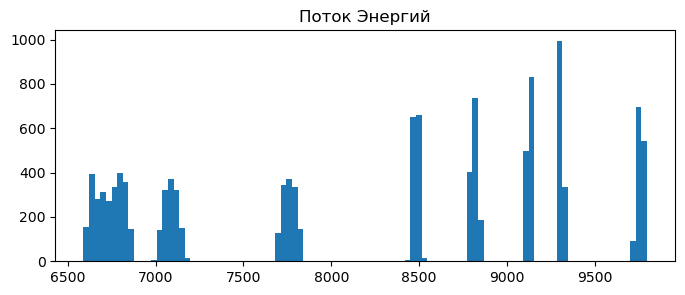

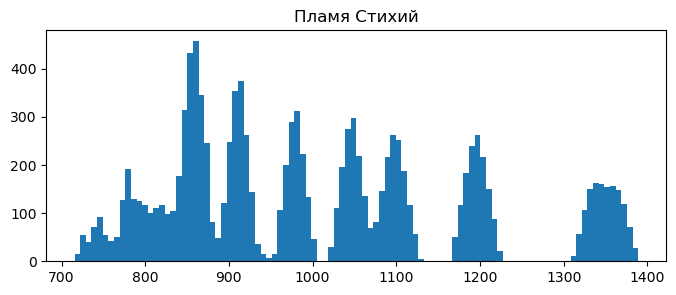

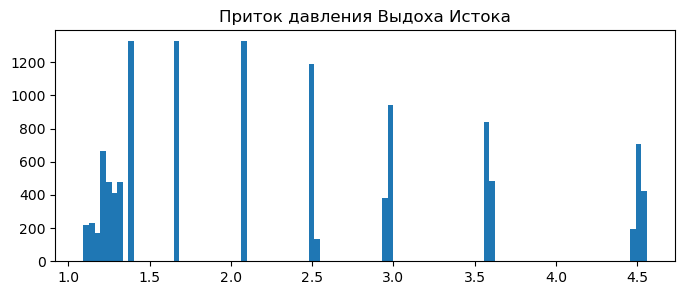

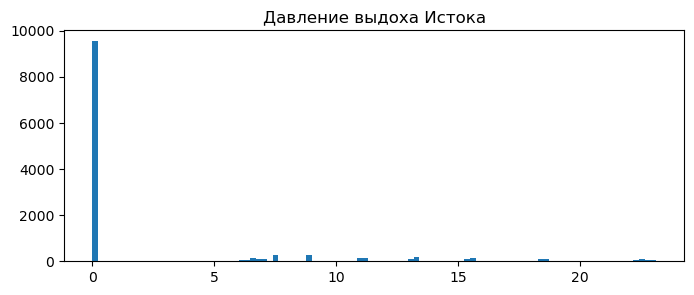

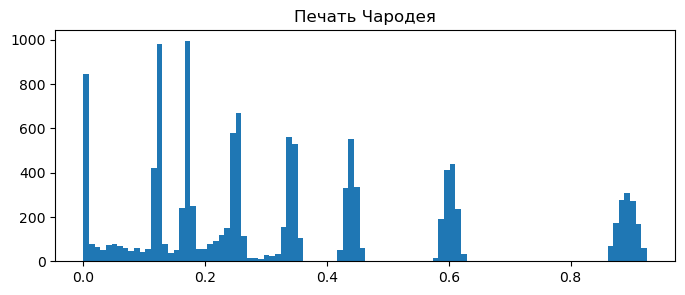

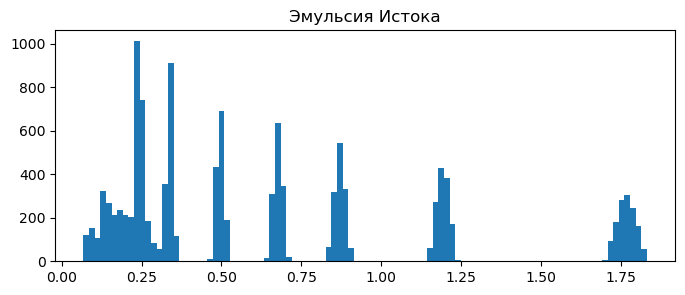

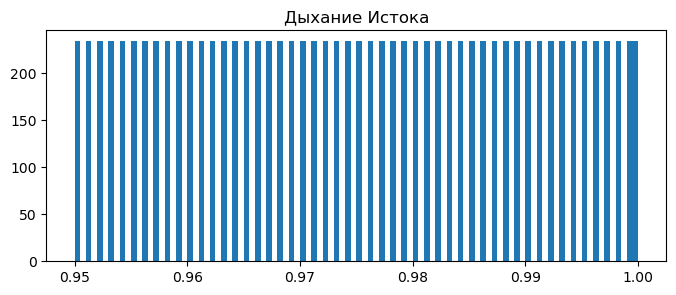

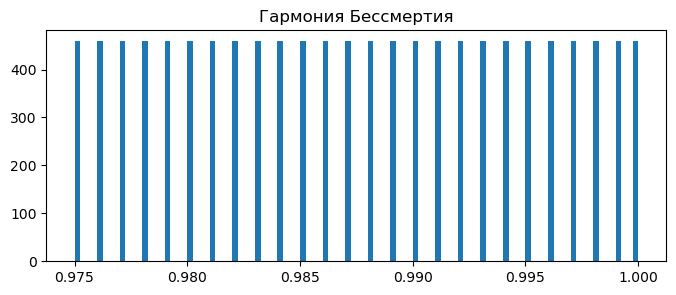

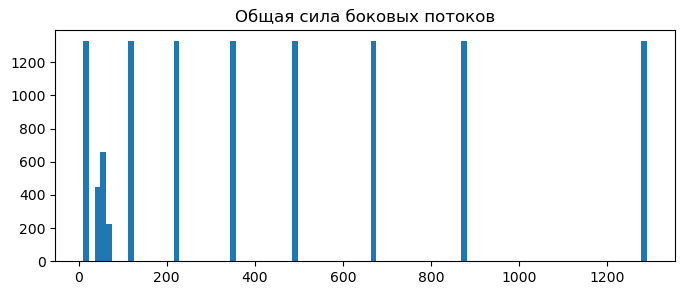

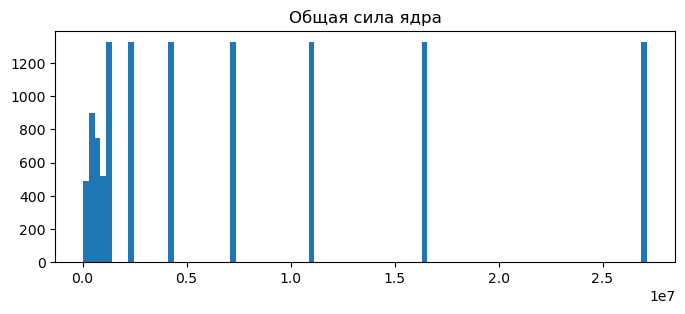

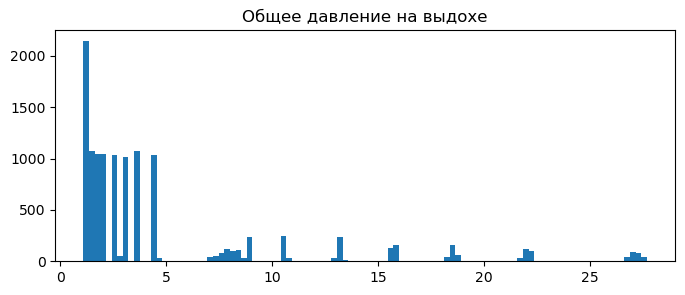

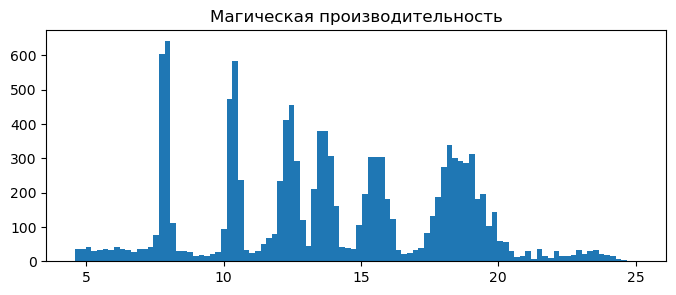

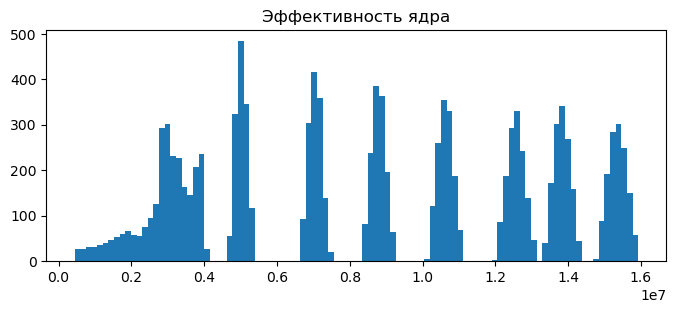

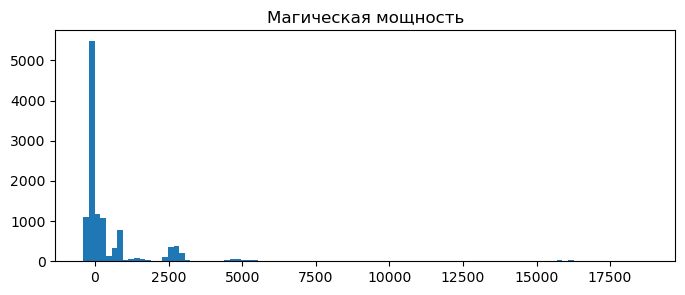

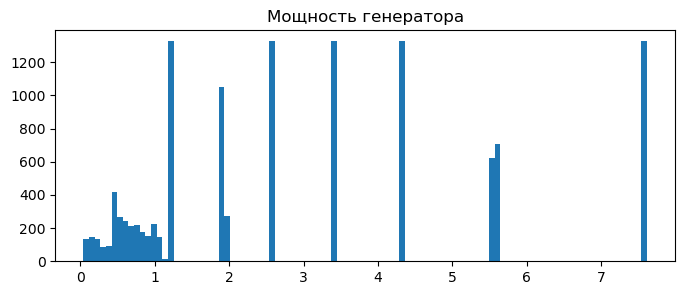

In [2238]:
for c_opt in column_names_opt_data:  
    plt.figure(figsize=(8, 3))
    plt.hist(opt_data[c_opt], bins=100)
    plt.xlim()
    plt.ylim()
    plt.title(c_opt)
    plt.show()

Явно аномальных наблюдений не выявлено, возможно стоит присмотреться к параметру 'Магическая мощность'. Поскольку он является производным, пока ничего предпринимать не стану.

###  Шаг 4. Произведем оценку мультиколлинеарности признаков
#### 4.1. построим корреляционную матрицу

<Axes: >

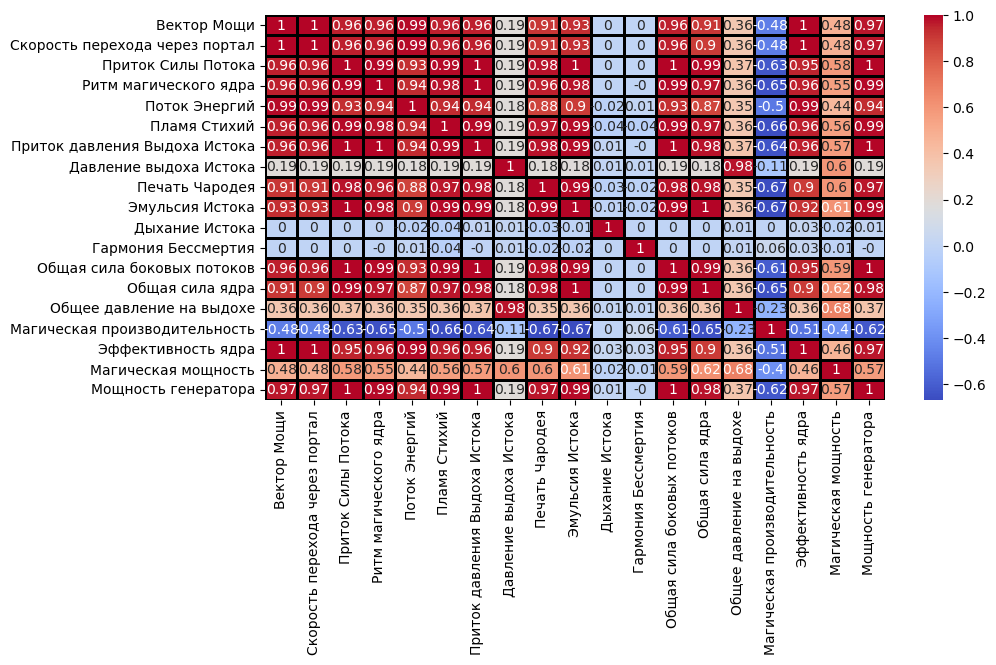

In [2239]:
correlation_matrix = opt_data.corr().round(2)

plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot = True, cmap= 'coolwarm', linewidths=1, linecolor='black')

Выводы:
- большое количество коррелирующих переменных, бедем применять методы борьбы с мультиколлинеарностью;
- нет признаков, имеющих сколько-то значимую линейную зависимость с целевым. Ранее собирался построить scatter plot распределения всех переменных к целевой, теперь не вижу смысла.

### Шаг 5. Объявим функцию нормализации данных <br>

Для большей объективности перемешаем все наблюдения.

In [2240]:
def normalize(data_to_norm):
    data_to_norm = shuffle(data_to_norm)
    pt = PowerTransformer()
    X = data_to_norm.drop('Гармония Бессмертия', axis=1)
    y = data_to_norm['Гармония Бессмертия']

    pt.fit(X)
    normalized_X = pd.DataFrame(pt.transform(X), columns=X.columns)

    control_y = y.to_frame(name='Гармония Бессмертия')
    pt.fit(control_y)
    pt_y_fit
    normalized_y = pd.DataFrame(pt.transform(data_to_norm[['Гармония Бессмертия']]), columns=['Гармония Бессмертия'])['Гармония Бессмертия']
    
    return [normalized_X, normalized_y, control_y]

### Шаг 6. Произведем отбор признаков

#### 6.1. В качестве оценочноый модели выберем Случайный лес: 
- деревянные модели более устойчивы к мультиколлинеарности;
- принцип работы основан на приросте информативности от выбранного параметра на каждом шаге.

In [2241]:
feature_selection_model = ensemble.RandomForestRegressor(n_estimators=10)

#### 6.2. Нормализуем данные

In [2242]:
normalized_data = normalize(opt_data)
normalized_X = normalized_data[0]
normalized_y = normalized_data[1]

control_y = normalized_data[2]

#### 6.3. Снижаем размерность, отсекая в цикле самые неинформативные параметры <br>
Критерий останова - значимость наименее важного признака превышает 1%.

In [2243]:
while True:
    feature_selection_model.fit(normalized_X, normalized_y)
    coefs = abs(pd.DataFrame(feature_selection_model.feature_importances_, 
                         columns=['Importance'], 
                         index=normalized_X.columns)).sort_values('Importance', ascending=False)
    importance_df = (coefs / coefs.sum()).round(2)
    
    least_important_feature_name = importance_df.iloc[-1].name
    least_important_feature_value = importance_df.iloc[-1][0]
    
    if importance_df.iloc[-1][0] > 0.01:
        print(importance_df)
        break
    else:
        normalized_X = normalized_X.drop(least_important_feature_name, axis=1)

                               Importance
Эффективность ядра                   0.17
Печать Чародея                       0.15
Поток Энергий                        0.13
Ритм магического ядра                0.11
Приток Силы Потока                   0.09
Мощность генератора                  0.08
Эмульсия Истока                      0.07
Приток давления Выдоха Истока        0.07
Дыхание Истока                       0.03
Общая сила боковых потоков           0.03
Пламя Стихий                         0.03
Магическая мощность                  0.02


### Шаг 7. Приступаем к обучению моделей

#### 7.1. Прогоним наши данные сразу через несколько моделей, возможно удастся выделить наиболее успешные

In [2244]:
models = {
    'Linear Regression': sklearn.linear_model.LinearRegression(),
    'L1': sklearn.linear_model.Lasso(),
    'L2': sklearn.linear_model.Ridge(),
    'ElasticNet': sklearn.linear_model.ElasticNet(),
    'Decision Tree': sklearn.tree.DecisionTreeRegressor(),
    'Random Forest': ensemble.RandomForestRegressor(),
    'AdaBoost': ensemble.AdaBoostRegressor(),
    'SVM': sklearn.svm.SVR(),
    'Gradient Boosting': XGBRegressor(),
    'Gradient Boosting + Lasso': XGBRegressor(reg_alpha=.2),
    'Gradient Boosting + Ridge': XGBRegressor(reg_lambda=.8),
    'Gradient Boosting + Lasso + Ridge': XGBRegressor(reg_alpha=.2, reg_lambda=.8)
}

#### 7.2. Объявим функцию, определяющую качество переданных моделей, и сразу обучим последние <br>
Ошибка составит крайне малое значение, в качестве метрики используем коэффициент детерминации. <br>
Для снижения вероятности переобучения модели применим кросс-валидацию.

In [2245]:
def model_scoring(model_list, X, y):
    for model_name in model_list:
        model = model_list[model_name]
        print(f'{model_name} \n Scores: {cross_val_score(estimator=model, X=X, y=y)}')
    return fitted_models

In [2246]:
model_scoring(models, normalized_X, normalized_y)

Linear Regression 
 Scores: [0.60912852 0.5982688  0.60388057 0.58893402 0.61645709]
L1 
 Scores: [-5.14521742e-04 -1.50611236e-04 -1.32330127e-04 -2.88823970e-05
 -7.54172147e-04]
L2 
 Scores: [0.52142165 0.51174934 0.52398873 0.5001629  0.52645638]
ElasticNet 
 Scores: [-5.14521742e-04 -1.50611236e-04 -1.32330127e-04 -2.88823970e-05
 -7.54172147e-04]
Decision Tree 
 Scores: [0.97807508 0.96113325 0.97111584 0.96957152 0.97222756]
Random Forest 
 Scores: [0.99256956 0.98942432 0.99021015 0.98954696 0.98959161]
AdaBoost 
 Scores: [0.10752394 0.14939291 0.16123096 0.15050501 0.11771045]
SVM 
 Scores: [0.73489697 0.7290517  0.71949384 0.73214555 0.74067882]
Gradient Boosting 
 Scores: [0.98644249 0.98602521 0.98499226 0.98565177 0.98679319]
Gradient Boosting + Lasso 
 Scores: [0.98601683 0.98516406 0.98647722 0.98620289 0.98627094]
Gradient Boosting + Ridge 
 Scores: [0.98655737 0.98596512 0.98537704 0.98690818 0.98722048]
Gradient Boosting + Lasso + Ridge 
 Scores: [0.98648231 0.9845003

{'Linear Regression': LinearRegression(),
 'L1': Lasso(),
 'L2': Ridge(),
 'ElasticNet': ElasticNet(),
 'Decision Tree': DecisionTreeRegressor(),
 'Random Forest': RandomForestRegressor(),
 'AdaBoost': AdaBoostRegressor(),
 'SVM': SVR(),
 'Gradient Boosting': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_

Модели Случайного леса и Градиентного бустинга показали очень хорошие результаты. <br>
Для дальнейшей работы выберу Градиентный бустинг, поскольку модель уже на этом этапе отрабатывает значительно быстрей, есть потенциал получить результат выше, как минимум, уменьшив величину скорости обучения, увеличив количество моделей в ансамбле и добавив регуляризацию.

#### 7.3. Подберем оптимальные параметры нашей модели

In [2247]:
model = XGBRegressor()

grid_params = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.005, 0.05, 0.5],
    'reg_lambda': [0.05, 0.5, 5]
}

grid = GridSearchCV(model, grid_params, cv=5, n_jobs=-1)
grid.fit(normalized_X, normalized_y)

grid.best_params_

{'learning_rate': 0.05, 'n_estimators': 1500, 'reg_lambda': 0.5}

#### 7.4. Обучим модель на полученных параметрах, посмотрим на результат и значимость параметров

In [2248]:
model.set_params(**grid.best_params_)

scores = cross_val_score(estimator=model, X=normalized_X, y=normalized_y)
mean_score = sum(scores) / 5
print(f'Scores: {scores}')
print(f'Mean score: {mean_score}')

model.fit(normalized_X, normalized_y)
coefs = abs(pd.DataFrame(model.feature_importances_, columns=['Importance'], index=normalized_X.columns)).sort_values('Importance', ascending=False)
importance_df = (coefs / coefs.sum()).round(2)
importance_df

Scores: [0.99158076 0.99230861 0.9923437  0.99248333 0.99373301]
Mean score: 0.9924898827623501


,Importance
Эмульсия Истока,0.21
Мощность генератора,0.15
Печать Чародея,0.13
Эффективность ядра,0.12
Приток давления Выдоха Истока,0.09
Поток Энергий,0.08
Ритм магического ядра,0.07
Приток Силы Потока,0.05
Общая сила боковых потоков,0.03
Дыхание Истока,0.03


#### 7.5. Снизим размерность, удаляя менее значимые до момента снижения точности модели

In [2249]:
normalized_X_reserved = normalized_X
following_model = XGBRegressor().set_params(**grid.best_params_)
previous_mean_score = mean_score.copy()

least_important_feature_name = importance_df.iloc[-1].name
normalized_X = normalized_X.drop(least_important_feature_name, axis=1)

while True:  
    following_model.fit(normalized_X, normalized_y)
    following_scores = cross_val_score(estimator=following_model, X=normalized_X, y=normalized_y)
    following_mean_score = sum(following_scores) / 5
    
    new_coefs = abs(pd.DataFrame(following_model.feature_importances_, columns=['Importance'], index=normalized_X.columns)).sort_values('Importance', ascending=False)        
    new_importance_df = (new_coefs / new_coefs.sum()).round(2)
    least_important_feature_name = new_importance_df.iloc[-1].name
    
    if mean_score - following_mean_score > 0.002:
        mean_score = previous_mean_score
        break
    else:
        model = following_model
        previous_mean_score = following_mean_score
        normalized_X_reserved = normalized_X
        normalized_X = normalized_X.drop(least_important_feature_name, axis=1)
        
model.fit(normalized_X_reserved, normalized_y)             
coefs = abs(pd.DataFrame(model.feature_importances_, columns=['Importance'], index=normalized_X_reserved.columns)).sort_values('Importance', ascending=False)        
importance_df = (coefs / coefs.sum()).round(2)
print(mean_score)
print(importance_df)

0.9924714909423786
                               Importance
Эмульсия Истока                      0.18
Мощность генератора                  0.17
Эффективность ядра                   0.14
Печать Чародея                       0.11
Приток давления Выдоха Истока        0.11
Поток Энергий                        0.11
Ритм магического ядра                0.08
Приток Силы Потока                   0.07
Дыхание Истока                       0.04


#### 7.5. Вернем начальные названия переменных (если меняли)

In [2250]:
# for alias in importance_df.index:
#     if alias in alias_dict.values():
#         for k, v in alias_dict.items():
#             if v == alias:
#                 importance_df = importance_df.rename(index={alias: k})
# importance_df

### Шаг 8. Подведение итогов
- Начальный датасет содержал в себе 17 параметров и целевой признак, в процессе преобразований были добавлены еще 7, для повышения информативности;
- Конечный датасет состоит всего из 9-ти колонок, на основе которых и была обучена модель без потери качества;
- Несмотря на высокую мультиколлинеарность, нам удалось собрать достаточно информации для крайне точного предсказания Гармонии Бессмертия;
- Исходя из результатов, появляется возможность в дальнейшем тратить меньше ресурсов на сбор и обработку информации в попытках предсказать состояние портала;
- Модель имеет потенциал к доработке, но поскольку мы имеем доступ к ограниченному количеству информации, на данном этапе это приведет к перееобучению и снижению обобщающей способности.

### Шаг 9. Облегчение работы с новыми данными

#### 9.1. Подготовка функций

In [2253]:
def data_preprocessing(data):
    
    data = data.drop(['Древний Ветер'], axis=1)
    indexes_to_zero = data['Температура выдоха Истока'][data['Температура выдоха Истока'] == 'Исток не вернул выдох'].index
    data.loc[indexes_to_zero, 'Давление выдоха Истока'] = 0
    data = data.drop(['Температура выдоха Истока'], axis=1)
    data['Пламя Стихий'] = data['Пламя Стихий'] + 273.15
    data['Температура вдоха Истока'] = data['Температура вдоха Истока'] + 273.15
    opt_data = data.copy()
    opt_data['Общая сила боковых потоков'] = data['Сила Левого Потока'] + data['Сила Правого Потока']
    opt_data = opt_data.drop(['Сила Левого Потока', 'Сила Правого Потока'], axis=1)
    opt_data['Общая сила ядра'] = data['Ритм магического ядра'] * data['Приток Силы Потока'] 
    opt_data['Общее давление на выдохе'] = data['Приток давления Выдоха Истока'] + data['Давление выдоха Истока']
    opt_data['Магическая производительность'] = data['Скорость перехода через портал'] / data['Эмульсия Истока'] 
    opt_data['Эффективность ядра'] = opt_data['Общая сила ядра'] / data['Эмульсия Истока']
    opt_data['Магическая мощность'] = opt_data['Общее давление на выдохе'] * data['Эмульсия Истока'] \
                                      * (data['Пламя Стихий'] - data['Температура вдоха Истока'])
    opt_data['Мощность генератора'] = (opt_data['Общая сила боковых потоков'] + opt_data['Приток Силы Потока']) \
                                      / opt_data['Поток Энергий']
    opt_data = opt_data.drop(['Температура вдоха Истока', 'Давление вдоха Истока'], axis=1)
 
    opt_data = opt_data[['Приток Силы Потока',
                         'Ритм магического ядра',
                         'Поток Энергий',
                         'Приток давления Выдоха Истока',
                         'Печать Чародея',
                         'Эмульсия Истока',
                         'Дыхание Истока',
                         'Эффективность ядра',
                         'Мощность генератора'
                        ]]

    data_to_norm = shuffle(opt_data)
    pt = PowerTransformer()
    pt.fit(opt_data)
    normalized_X = pd.DataFrame(pt.transform(opt_data), columns=opt_data.columns)

    return normalized_X

#### 9.2. Предсказание значений

In [2263]:
data = raw_data
X = data_preprocessing(data)
pt = PowerTransformer()
pt.fit(control_y)
predictions = pt.inverse_transform(pd.DataFrame(model.predict(X), columns=['Гармония Бессмертия']))
predictions = pd.DataFrame(predictions, columns=['Гармония Бессмертия'])
predictions

,Гармония Бессмертия
0,0.975354
1,0.976541
2,0.975287
3,0.975466
4,0.975491
...,...
11929,0.998695
11930,0.999594
11931,0.999618
11932,0.999584
